# The Elder Scrolls Online: Furnishing Plan Materials

![Carousel made in Elder Scrolls Online housing](images/carousel.jpg 'Thanksgiving scene made in ESO housing')


## Introduction

The Elder Scrolls Online (ESO) released the Homestead update in February 2017, adding player housing and furnishings to the game. Homes can be bought with ESO's primary currency, gold, or with their cash currency, crowns, and contain a wide range of fixed terrain and structures. Movable furnishings can be added and removed to either decorate the existing structures or transform them into unrecognizable environments. While some furnishings can be bought from NPC vendors or found through gameplay, most are crafted, and major updates to ESO typically add a new batch of crafting plans for players to collect. Crafted furnishings can be traded and sold, and make up a significant portion of the game's economy.
<br/><br/>

![](https://raw.githubusercontent.com/racheldelong/ESO-Crafting-Material-Prices/main/images/CKy_prices2.png)
###### *Furnishing material prices for fall and winter 2020 - 2021, and spring through fall 2022. Dotted vertical lines mark new content patches, with lighter gray for the start of public testing, and darker gray for the official release.*

For my [ESO Crafting Materials](https://github.com/racheldelong/ESO-Crafting-Material-Prices), I analyzed the price of furnishing materials over time and discussed some of the possible explanations for the demonstrated price increases. While the most extreme increase coincided with the start of ESO's winter holiday event (where players are tasked with donating specific furnishings in exchange for holiday-themed rewards), most other price increases began in the weeks between the public testing and official release of new content patches.

For my Data Analysis 2 project, I decided to take a closer look at the relationship between past content updates in *The Elder Scrolls Online* and the furnishing materials required to craft new plans added by each, and the impact each patch would likely have on demand.

---

__Objective:__ analyze the likely impact of furnishing plans added per patch on the price of furnishing materials in The Elder Scrolls Online.

---

#### Import modules

In [1]:
# import modules
import pandas as pd

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Data

To create a dataframe of all plans in The Elder Scrolls Online, I'm combining two spreadsheets from Google Sheets: [Tsu's Magical Pricing Assistant](https://docs.google.com/spreadsheets/d/1gA3gLV_trvozQjHANvCWIrzmCMhEGdf6dm7N_U2CYuY/), a tool to help players calculate sales prices for their crafted furnishings, and [ESO Furnishings Helper by Sapphire_Ocelot](https://docs.google.com/spreadsheets/d/11XxNt07znE3cHqWMecO-NxSjNWWnaA8hMA6uDV_53O8/), a tool for tracking which furnishing plans a player has learned. Some furnishing plans are missing in one or the other, and Tsu's Pricing Assistant is missing patch data (while the Furnishings Helper is missing crafting materials). Combining them and removing any duplicates should solve most of the issues with either spreadsheet alone.

For newer plans not yet added to either spreadsheet, I'm using [The Unofficial Elder Scrolls Pages](https://en.uesp.net/wiki/Main_Page) to find all craftable furnishings in the 'druidic' and 'High Isle' styles featured in the Firesong DLC.

Any missing data will be filled via [ESO-Hub.com](https://eso-hub.com/en/housing) furnishing pages, and anything still missing will be added manually via [MMO Fashion](https://eso.mmo-fashion.com/furnishings/).

Patch dates in the ESO Mat Prices Google Sheets file are from either UESP.net or the news section of [The Elder Scrolls Online](https://www.elderscrollsonline.com/en-us/news).

##### Import data

In [2]:
# import tsu's pricing assistant furniture catalog
df1 = pd.read_csv("data/FurnitureCatalog.tsv", sep="\t")
df1.tail(3)

,Furniture Name,Y/N,Quality,Crafting Station,Category,Mat1,Q1,MatPrice1,Mat2,Q2,...,MatPrice4,Mat5,Q5,MatPrice5,Mat6,Q6,MatPrice6,Rarity Bonus,Total,Rounded Total
2468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [3]:
# import eso furnishing helper plans
df2 = pd.read_csv("data/Furnishings_Helper_Plans.tsv", sep="\t")
df2.tail(3)

,CRAFTABLE PLANS LIST,Y/N,QUALITY,TYPE,STATION,CATEGORY,STYLE,RELEASE,NOTES
2502,"Wood Elf Wall Hide, Fur",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN
2503,"Wood Elf Wall Hide, Pierced",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN
2504,"Wood Elf Wall Hide, Spotted",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN


In [4]:
# import eso mat prices patches
sheet_id = "15ooJmi30BiE3ZhbNsGNG0Ct2gL-tRcoFMbLKLjQGqbU"
sheet_name = "patches"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df3 = pd.read_csv(url)
df3.tail(3)

,Update,Patch,Release,PTS
21,34,High Isle,06-06-22,04-18-22
22,35,Lost Depths,08-22-22,07-11-22
23,36,Firesong,11-01-22,09-19-22


### Clean data

In [5]:
def update_items(df):
    """Correct typos and outdated item names."""

    updated_names = {
        "Azura": "Azure", # typos
        "Wrough-Iron": "Wrought-Iron",
        "On-The": "on-the",
        "Deadlands, Brazier,": "Deadlands Brazier,",
        "Reachman": "Reachmen", # item name changes
        "Leyawiin Cabinet, Formal": "Leyawiin Wardrobe, Formal", 
        "Murkmire Lamp, Shell": "Murkmire Candle, Standing Shell", 
        "Solitude Cabinet, Narrow Open Filled": "Solitude Bookcase, Narrow Open Filled"
    }

    # replace dictionary key with value
    for key, value in updated_names.items():
        df["Name"] = df["Name"].str.replace(key, value)

    # remove--no longer craftable
    df = df[df["Name"].str.contains("Khajiit Statue, Guardian") == False]
    df = df.reset_index(drop=True)

    return df

In [6]:
# housing material names w/ shortened column names
mat_names = {
    "Regulus": "Regulus",
    "Bast": "Bast",
    "Heartwood": "Wood",
    "Ochre": "Ochre",
    "Alchemical Resin": "Resin",
    "Mundane Rune": "Rune",
    "Decorative Wax": "Wax",
    "Clean Pelt": "Pelt",
}

##### df1 - Furniture Catalog

###### Create columns for each furnishing material and get value from matching Mat1 - Mat6 columns in original dataframe so that the use of each material can be combined by patch. General crafting materials aren't needed.

In [7]:
# move mat quantities to new columnseeeeeeee
for i in range(6):

    # generate numbered column names
    df_mat = "Mat" + str(i + 1)
    df_quant = "Q" + str(i + 1)

    # check the values in the generated column name
    for row, value in enumerate(df1[df_mat]):

        # check if material is a housing mat
        if value in mat_names:

            # add quantity to mat column
            df1.at[row, mat_names[value]] = df1.at[row, df_quant]

df1.head(3)

,Furniture Name,Y/N,Quality,Crafting Station,Category,Mat1,Q1,MatPrice1,Mat2,Q2,...,Total,Rounded Total,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
0,"Alchemical Apparatus, Condenser",NaN,Legendary,Alchemy,Workshop,Alchemical Resin,13.0,30.0,Regulus,15.0,...,15025,16000,13.0,NaN,9.0,NaN,NaN,15.0,NaN,NaN
1,"Alchemical Apparatus, Master",NaN,Legendary,Alchemy,Workshop,Alchemical Resin,13.0,30.0,Regulus,15.0,...,28225,29000,13.0,NaN,9.0,11.0,NaN,15.0,NaN,NaN
2,"Alinor Amphora, Delicate",NaN,Fine,Provisioning,Hearth,Decorative Wax,5.0,750.0,Mundane Rune,5.0,...,15510,16000,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN


###### Rename columns, update outdated item names and correct typos, remove irrelevant columns, and drop empty rows.

In [8]:
# rename columns
df1.rename(columns={"Furniture Name": "Name"}, inplace=True)

# correct old item names
df1 = update_items(df1)

# remove pricing-related columns
cols_to_drop = ["Y/N", "Rarity Bonus", "Total", "Rounded Total", "Crafting Station"]

# add numbered mat columns to list of cols to remove
for i in range(6):
    # create numbered column names
    df_price = "MatPrice" + str(i + 1)
    df_mat = "Mat" + str(i + 1)
    df_quant = "Q" + str(i + 1)

    cols_to_drop = cols_to_drop + [df_price, df_mat, df_quant]

# remove cols
df1 = df1.drop(columns=cols_to_drop)

# remove any rows where all values are NaN
df1 = df1.dropna(how="all")

df1.tail(3)

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
2400,"Wood Elf Wall Hide, Fur",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2401,"Wood Elf Wall Hide, Pierced",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2402,"Wood Elf Wall Hide, Spotted",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


##### df2 - Plans Tracker

###### Rename columns, replace outdated item names and typos, replace random unicode character that would interfere with plan name matching, remove irrelevant columns, and drop empty rows.

In [9]:
# change column names
df2 = df2.rename(
    columns={
        "CRAFTABLE PLANS LIST": "Name",
        "CATEGORY": "Category",
        "RELEASE": "Patch",
        "QUALITY": "Quality",
    }
)

# fix old item names
df2 = update_items(df2)

# remove invisible unicode character
df2 = df2.replace(to_replace="\xa0", value=" ", regex=True)

# remove irrelevant columns
df2.drop(columns=["Y/N", "TYPE", "STYLE", "NOTES", "STATION"], inplace=True)

# remove empty rows
df2 = df2.dropna(how="all")

df2.tail(3)

,Name,Quality,Category,Patch
2502,"Wood Elf Wall Hide, Fur",Fine,Undercroft,Homestead
2503,"Wood Elf Wall Hide, Pierced",Fine,Undercroft,Homestead
2504,"Wood Elf Wall Hide, Spotted",Fine,Undercroft,Homestead


###### Merge the 'Patch' values from df2 with plans in df1, and remove overlapping plans from df2 so that only plans without any material data are left in df2.

In [10]:
# left merge df2 plans to add patch values to plans
df1 = df1.merge(df2[["Name", "Patch"]], how="left", on=["Name"])

# remove anything in df1 from df2
df2 = df2[~df2["Name"].isin(df1["Name"])]
df2 = df2.reset_index(drop=True)

df2.shape

(104, 4)

##### df3 - Patches

###### Convert release date column to datetime and use date to sort patches. Drop the PTS start date column, and replace nan values.

In [11]:
# convert patch release date column to datetime
df3["Release"] = pd.to_datetime(df3["Release"])

# sort patches by date released
df3 = df3.sort_values(by=["Release"])

# drop pts column (used for ESO Mat Prices project)
df3 = df3.drop(columns=["PTS"])

# fill missing values
df3 = df3.fillna("-")

df3.head(3)

,Update,Patch,Release
0,13,Homestead,2017-02-06
1,14,Morrowind,2017-06-05
2,15,Horns of the Reach,2017-08-14


###### Remove Homestead patch to focus on plans added after initial housing system launch.

In [12]:
# create patches df without homestead data
patches = df3.drop(0)
patches = patches.reset_index(drop=True)

patches.head(3)

,Update,Patch,Release
0,14,Morrowind,2017-06-05
1,15,Horns of the Reach,2017-08-14
2,16,Clockwork City,2017-10-23


#### Get missing data

In [13]:
def find_text(source, start_str, end_str):
    """Return text between start_str and end_str from source."""

    # get the location of the end of start_str in source
    match = re.search(start_str, source)
    index = match.end()

    # use index as beginning of filtered string
    filtered_str = source[index:]

    # get the location of the start of end_str in source
    match = re.search(end_str, filtered_str)
    index = match.start()

    # use index as end of filtered string
    filtered_str = filtered_str[:index]

    return filtered_str

In [14]:
def mat_cols(mat_list):
    """Return a dictionary of column values from a list of material quantity strings."""
    # dictionary for returned values
    mat_col = {}

    for material in mat_list:
        for mat_name in mat_names.keys():

            # check for housing material
            if mat_name in material:

                # remove material name and space before quantity
                regex_str = mat_name + " "
                quantity = re.sub(regex_str, "", material)
                # convert remaining material string to integer and set as quantity
                quantity = int(quantity)
                # use shortened material name as key and add to dictionary
                mat_col[mat_names[mat_name]] = quantity

    return mat_col

In [15]:
def get_cols(plan_name):
    """Return a dictionary of column values for a plan."""
    # create url for plan from Name value
    # remove commas and replace spaces with dashes
    plan_str = plan_name.replace(",", "")
    plan_str = plan_str.replace(" ", "-")

    # convert to lowercase
    plan_str = plan_str.lower()

    # create ESO-Hub plan url
    # (ESO-Hub plan pages were significantly easier to work with than UESP's)
    plan_url = f"https://eso-hub.com/en/furniture/{plan_str}"

    # get all text from url
    page = requests.get(plan_url)
    data = BeautifulSoup(page.content, "html.parser")
    data = data.get_text()

    # get column data from text

    plan_info = {}

    # name column
    plan_info["Name"] = plan_name

    # patch column
    dlc_str = "added to the game with the "

    if dlc_str in data:
        plan_patch = find_text(data, dlc_str, " DLC")
        plan_info["Patch"] = plan_patch

    # category column
    cat_str = "ESO Housing Library - All Housing Items\n"

    if cat_str in data:
        plan_cat = find_text(data, cat_str, "\n")
        plan_info["Category"] = plan_cat

    # quality column
    qual_str = "Quality:"

    if qual_str in data:
        plan_qual = find_text(data, qual_str, "\n")
        plan_info["Quality"] = plan_qual

    # material columns
    plan_mats = {}

    mat_str = "Ingredients"

    if mat_str in data:

        plan_mats = find_text(data, mat_str, "Required skills:")

        # fix formatting, remove parentheses and extra whitespace
        plan_mats = re.sub(r":\s+|\(|\)\s$|\)", "", plan_mats)

        # convert into list
        plan_mats = plan_mats.splitlines()

        # create key:val pairs for columns and mat quantities
        plan_mats = mat_cols(plan_mats)

    # combine plan_info and plan_mats dictionaries
    plan_cols = plan_info | plan_mats

    return plan_cols

In [16]:
def check_mats(df):
    """Remove rows in dataframe with no recorded housing materials."""
    cols = []
    # find which mat columns are in df
    for col in mat_names.values():
        if col in df.columns:
            cols.append(col)

    # use sum of mats to find rows with none recorded
    df["Mat Sum"] = df[cols].fillna(0).sum(axis=1)

    # remove rows without mats
    df = df[df["Mat Sum"] != 0]
    df = df.reset_index(drop=True)

    return df

##### df2 - Plans Tracker

###### Get missing crafting material data from ESO-Hub for all plans left in df2.

In [17]:
try:
    # read in previously scraped data, if available
    df2 = pd.read_csv("scraped_data/df2.tsv", sep="\t")

except FileNotFoundError:
    # scrape data for remaining plans in df2
    for row, plan in enumerate(df2["Name"]):
        # get plan info dictionary using ESO-HUB plan page
        col_data = get_cols(plan)

        # fill cols, with dict key as col name, dict value as col value
        for key, value in col_data.items():
            df2.at[row, key] = value

    # save scraped data to folder
    df2.to_csv("scraped_data/df2.tsv", sep="\t", index=False)

###### Remove any plans left with 0 materials after attempting to get data from ESO-Hub, since they're most likely not craftable.

In [18]:
# remove remaining plans without mats
df2 = check_mats(df2)

##### Firesong DLC

In [19]:
def get_plans(url):
    """Return a list of furnishings from the url."""
    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    data = soup.find_all("table")

    # create df from table
    df = pd.read_html(str(data))[0]

    # only keep furnishing name column
    df = df[["Name"]]

    # clean name values
    df["Name"] = df["Name"].str.replace(r" \(page\)", "", regex=True)

    return df

###### Since both the Plans tracker and Furniture Catalog data were missing furnishing plans from the most recent Firesong DLC, lists of those furnishings need to be added. Since the main style added was 'Druidic' (and 'Firesong', also grouped under 'Druidic'), get the list of all furnishings of that style from UESP.

In [20]:
try:
    # read in previously scraped data, if available
    druid = pd.read_csv("scraped_data/druid.tsv", sep="\t")

except FileNotFoundError:
    # get all druidic plans from UESP.net
    # ESO-Hub's update furnishings pages seem to be datamined, and included content not actually available in-game
    druid = get_plans("https://en.uesp.net/wiki/Online:Druid_Furnishings")

    # save scraped data to folder
    druid.to_csv("scraped_data/druid.tsv", sep="\t", index=False)

druid.tail(3)

,Name
51,"Flowers, Galen Sea Daffodil"
52,The Druid King's Ivy Throne
53,Vulk'esh Egg


###### The rest of the new Firesong DLC plans are High Isle style furnishings. Get all High Isle furnishings from UESP.

In [21]:
try:
    # read in previously scraped data, if available
    high_isle = pd.read_csv("scraped_data/high_isle.tsv", sep="\t")

except FileNotFoundError:
    # get all high isle style plans from UESP.net
    high_isle = get_plans("https://en.uesp.net/wiki/Online:High_Isle_Furnishings")

    # save scraped data to folder
    high_isle.to_csv("scraped_data/high_isle.tsv", sep="\t", index=False)

high_isle.tail(3)

,Name
113,"Tree, Conical Cypress"
114,"Tree, Forked Cypress"
115,"Tree, Tall Conical Cypress"


###### Since most High Isle plans were already added in the High Isle and Lost Depths patches, remove any items in the high_isle dataframe that are already in df2.

In [22]:
# only a few of these are new, so duplicates will need to be removed
# filter out anything already included in df2
high_isle = high_isle[~high_isle["Name"].isin(df2["Name"])]
high_isle = high_isle.reset_index(drop=True)

high_isle.shape

(42, 1)

###### Combine high_isle and druid plans into firesong dataframe.

In [23]:
# combine firesong patch furnishings
firesong = pd.concat([druid, high_isle])
firesong = firesong.reset_index(drop=True)

###### Fill in missing plan data for firesong plans via ESO-Hub.

In [24]:
try:
    # read in previously scraped data, if available
    firesong = pd.read_csv("scraped_data/firesong.tsv", sep="\t")

except FileNotFoundError:
    # scrape missing data for each plan
    for row, plan in enumerate(firesong["Name"]):

        # get plan info dictionary using ESO-HUB plan page
        col_data = get_cols(plan)

        # fill cols with dict key as col name, dict value as col value
        for key, value in col_data.items():
            firesong.at[row, key] = value

    # save scraped data to folder
    firesong.to_csv("scraped_data/firesong.tsv", sep="\t", index=False)

###### Remove any firesong plans that still have 0 materials listed, since they're most likely not craftable.

In [25]:
# remove rows without mats
firesong = check_mats(firesong)

firesong.tail(3)

,Name,Patch,Category,Quality,Pelt,Wax,Rune,Resin,Bast,Wood,Ochre,Regulus,Mat Sum
47,"High Isle Nightstand, Dainty Wood",Firesong,Suite,Fine,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0
48,"High Isle Nightstand, Wood",Firesong,Suite,Superior,NaN,5.0,NaN,NaN,NaN,9.0,NaN,NaN,14.0
49,"High Isle Teapot, Copper",Firesong,Hearth,Epic,NaN,NaN,NaN,9.0,NaN,7.0,NaN,13.0,29.0


### Combine plan dataframes

In [26]:
# combine plans from df1, df2, and firesong
plans = pd.concat([df1, df2, firesong])
plans = plans.reset_index(drop=True)

plans.shape

(2559, 13)

###### Remove any plan names listed more than once.

In [27]:
# remove any duplicates
duplicates = plans.duplicated(["Name"], keep="first")

plans = plans[~duplicates]
plans = plans.reset_index(drop=True)

plans.shape

(2555, 13)

###### Check again for plans with 0 crafting materials and attempt to fill via ESO-Hub.

In [28]:
# find sum of mats for each plan to check for missing mat data
plans["Mat Sum"] = plans[mat_names.values()].fillna(0).sum(axis=1)

try:
    # read in previously scraped data, if available
    plans = pd.read_csv("scraped_data/plans.tsv", sep="\t")

except FileNotFoundError:
    # scrape data for any plans still without mats
    for row, matsum in enumerate(plans["Mat Sum"]):
        if matsum == 0:
            plan = plans.at[row, "Name"]

            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv("scraped_data/plans.tsv", sep="\t", index=False)

###### Change values in Quality column to lowercase and remove any extra whitespace so that values match.

In [29]:
# convert to lowercase and remove excess whitespace
plans["Quality"] = plans["Quality"].str.strip()
plans["Quality"] = plans["Quality"].str.lower()
plans["Quality"].unique()

array(['legendary', 'fine', 'superior', 'epic', 'standard'], dtype=object)

In [30]:
# check plans df category values
plans["Category"].unique()

array(['Workshop', 'Hearth', 'Gallery', 'Structures', 'Dining', 'Suite',
       'Library', 'Courtyard', 'Lighting', 'Parlor', 'Undercroft',
       'Conservatory', 'Miscellaneous', nan, 'library', 'Services'],
      dtype=object)

###### Change value in Category column to match others, and check for any plans with no listed Category.

In [31]:
# fix lowercase 'library' category
plans["Category"] = plans["Category"].str.replace("library", "Library")

# check for NaN values in the Category column
plans[plans["Category"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum
598,"Dark Elf Tent, Canopy",legendary,NaN,12.0,NaN,8.0,NaN,NaN,15.0,15.0,NaN,Elsweyr,50.0
1609,"Obelisk, Lord Hircine Ritual",superior,NaN,7.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,Wolfhunter,17.0


###### Attempt to fill in Category data from ESO-Hub.

In [32]:
try:
    # read in previously scraped data, if available
    plans = pd.read_csv("scraped_data/plans_cat.tsv", sep="\t")

except FileNotFoundError:
    for row, plan in enumerate(plans["Name"]):

        # scrape missing data for plans without a Category value
        if pd.isna(plans["Category"][row]):

            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv("scraped_data/plans_cat.tsv", sep="\t", index=False)

In [33]:
# check again for missing categories
plans[plans["Category"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum


###### Check for missing Patch column values.

In [34]:
# check for any plans with missing patch values
plans[plans["Patch"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum
607,Deadlands Archway,epic,Structures,NaN,NaN,7.0,13.0,NaN,NaN,NaN,7.0,NaN,27.0


###### Attempt to fill missing Patch value, and check again.

In [35]:
try:
    # read in previously scraped data, if available
    plans = pd.read_csv("scraped_data/plans_patch.tsv", sep="\t")

except FileNotFoundError:
    for row, plan in enumerate(plans["Name"]):
        # scrape missing data for plans without a Category value
        if pd.isna(plans["Patch"][row]):

            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv("scraped_data/plans_patch.tsv", sep="\t", index=False)

In [36]:
plans[plans["Patch"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum


###### Check for patches values not listed in patches column of plans dataframe.

In [37]:
# check for patch values in patches df but not plans df
for patch in patches["Patch"].unique():
    if patch not in plans["Patch"].unique():
        print(patch)

Morrowind
Horns of the Reach
Clockwork City
Wrathstone
Dragonhold
The Deadlands


###### Check for patch column values not listed in patches dataframe.


In [38]:
# check for patch values in plans df but not patches df
for patch in plans["Patch"].unique():
    if patch not in patches["Patch"].unique():
        print(patch)

Homestead
Morrowind / Clockwork
Deadlands


In [39]:
# correct inconsistent deadlands patch value
plans["Patch"] = plans["Patch"].str.replace("^Deadlands", "The Deadlands", regex=True)

###### Replace 'Morrowind / Clockwork' values with specific patch added using text files, and check if any patch values in plans dataframe are missing from patches dataframe.

In [40]:
# create lists from text files
mw = open("data/morrowind.txt", "r")
mw = mw.read().splitlines()

cwc = open("data/clockwork_city.txt", "r")
cwc = cwc.read().splitlines()

hotr = open("data/horns_of_the_reach.txt", "r")
hotr = hotr.read().splitlines()

# fix 'Morrowind / Clockwork' patch values using lists
for row, plan in enumerate(plans["Name"]):
    if plan in mw:
        plans.at[row, "Patch"] = "Morrowind"
    elif plan in cwc:
        plans.at[row, "Patch"] = "Clockwork City"
    elif plan in hotr:
        plans.at[row, "Patch"] = "Horns of the Reach"

In [41]:
# check for patch values in plans df but not patches df
for patch in plans["Patch"].unique():
    if patch not in patches["Patch"].unique():
        print(patch)

Homestead


## Calculate total plans and materials by update added

###### Find total plans added per update

In [42]:
# find total plans added per patch
total_plans = plans.groupby("Patch")["Name"].count()

# merge with patches df
patches = patches.merge(total_plans, how="left", on=["Patch"])

# fix plan count column name
patches = patches.rename(columns={"Name": "Plans"})

###### Find total mats used by plans per update

In [43]:
# find sum of mats used by plans added in each update
mats_sum = plans.groupby("Patch").sum(numeric_only=True)

# merge with patches df
patches = patches.merge(mats_sum, how="left", on=["Patch"])
patches = patches.drop(columns=["Mat Sum"])

patches = patches.fillna(0)

In [44]:
pd.set_option('display.max_columns', None)
display(patches)

,Update,Patch,Release,Plans,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
0,14,Morrowind,2017-06-05,273.0,1045.0,875.0,0.0,1298.0,860.0,1140.0,595.0,38.0
1,15,Horns of the Reach,2017-08-14,16.0,108.0,56.0,0.0,128.0,35.0,113.0,29.0,13.0
2,16,Clockwork City,2017-10-23,68.0,197.0,64.0,0.0,319.0,46.0,516.0,0.0,0.0
3,17,Dragon Bones,2018-02-12,11.0,57.0,53.0,9.0,94.0,24.0,79.0,53.0,0.0
4,18,Summerset,2018-06-05,164.0,456.0,599.0,500.0,711.0,593.0,420.0,236.0,0.0
5,19,Wolfhunter,2018-08-13,11.0,46.0,87.0,62.0,85.0,69.0,56.0,20.0,9.0
6,20,Murkmire,2018-10-22,75.0,197.0,178.0,75.0,279.0,270.0,16.0,124.0,9.0
7,21,Wrathstone,2019-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,22,Elsweyr,2019-05-20,158.0,622.0,330.0,398.0,503.0,705.0,217.0,426.0,15.0
9,23,Scalebreaker,2019-08-12,13.0,82.0,63.0,83.0,108.0,43.0,67.0,15.0,0.0


### ESO Patches since Homestead

The number of plans added per patch varies significantly. The largest additions of new craftable furnishings were added in the Morrowind, Summerset, Elsweyr, Greymoor, and Blackwood chapter DLC (main content for the year), all of which added over 100 new plans. High Isle, despite being the chapter DLC for 2022, added only 47, backing up complaints that the number of craftable furnishings added in 2022 has been much smaller than expected.

## Visualizations

In [45]:
# plot formatting
plt.rcParams["figure.dpi"] = 150

# pie chart wedge colors
colors = {
    "regulus": "#98CABB",
    "bast": "#E9D985",
    "wood": "#ff6d00",
    "ochre": "#C4D9CE",
    "resin": "#eef0d0",
    "rune": "#46B0B1",
    "wax": "#F4B34E",
    "pelt": "#DBE3CE",
}

# pie chart
pie = {"labeldistance": None, "radius": 1}

# value for pie chart explode values
explode = 0.05

# pie chart legend
legend = {
    "facecolor": None,
    "edgecolor": None,
    "fontsize": 6,
    "labelcolor": "#436161",
    "framealpha": 0,
    "ncol": 8,
    "loc": "lower center",
}

# plot titles etc
titlefnt = {"fontsize": 8, "color": "slategray"}

# text for number of plans at center of pie charts
countfnt = {
    "color": "#436161",
    "horizontalalignment": "center",
    "verticalalignment": "center",
    "alpha": 0.3,
}

# horizontal bar chart plan total labels
bar_text = {
    "va": "center",
    "ha": "left",
    "size": 8,
    "c": colors["rune"],
    "weight": "semibold",
}

# plans over time patch name
bar_text2 = {
    "ha": "left",
    "va": "center",
    "c": "slategray",
    "style": "oblique",
    "size": 8,
    "alpha": 0.8,
}

# bar chart yearly totals
bar_text3 = {
    "size": 50,
    "c": "#8fa3a3",
    "weight": "black",
    "ha": "right",
    "va": "center",
    "alpha": 0.25,
}

# start and end dates for plans over time bar chart
xl2019 = datetime(2017, 1, 1, 0, 0, 0)
xr2022 = datetime(2022, 12, 31, 0, 0, 0)

###### Adjust data for patch plan materials pie chart.

In [46]:
chart_cols = [
    "Patch",
    "Regulus",
    "Bast",
    "Wood",
    "Ochre",
    "Resin",
    "Rune",
    "Wax",
    "Pelt",
]

# keep patch names and mat sums only
mats_sum = patches[chart_cols]
mats_sum = mats_sum.set_index("Patch")

# set mats as row index, and patches as columns
mats_sum = mats_sum.transpose()

# keep patch names and total plans only
total_plans = patches[["Patch", "Plans"]]
total_plans = total_plans.set_index("Patch")

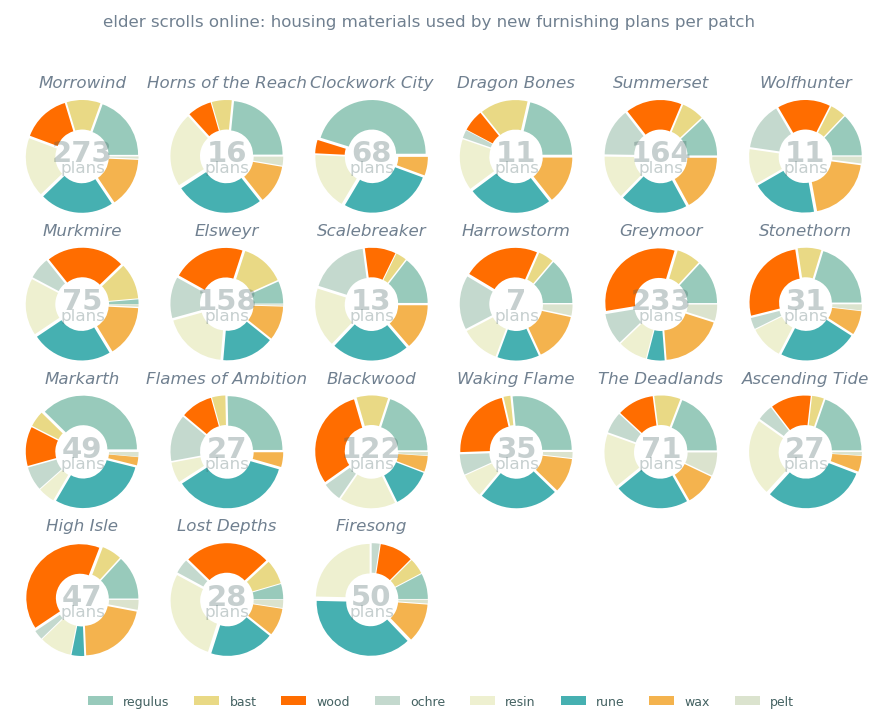

In [47]:
# pie charts for each update
fig, axs = plt.subplots(4, 6, dpi=150, figsize=(8, 5), facecolor="w")
plt.subplots_adjust(hspace=0.1, wspace=-0.3)
fig.suptitle(
    "elder scrolls online: housing materials used by new furnishing plans per patch",
    **titlefnt,
)

# remove patches with 0 plans
pie_mats = mats_sum.loc[:, mats_sum.sum(axis=0) > 0]

updates = list(pie_mats.columns)
labels = colors.keys()

# create list for chart explode
expl = [explode] * len(colors.keys())

# create a pie chart subplot for each update
for update, ax in zip(updates, axs.ravel()):
    pie_mats[update].plot.pie(
        ax=ax,
        labels=list(pie_mats.index),
        explode=expl,
        colors=[colors[key.lower()] for key in labels],
        wedgeprops=dict(width=0.55),
        **pie,
    )

    ax.set_title(label=update, style="italic", y=0.92, **titlefnt)
    ax.set_ylabel("")

    # label for number of plans at center of chart
    ax.text(
        x=-0,
        y=0.05,
        s=str(int(total_plans.at[update, "Plans"])),
        weight="semibold",
        size=14,
        **countfnt,
    )
    # 'plans' under value at center of chart
    ax.text(x=0.01, y=-0.22, s="plans", size=8, weight="light", **countfnt)

# add legend to bottom center
plt.figlegend(labels=labels, bbox_to_anchor=(0.51, 0.04), **legend)

# remove empty plots
fig.delaxes(axs[3][3])
fig.delaxes(axs[3][4])
fig.delaxes(axs[3][5])

fig.savefig("images/ESOPlanMats_patches.png", bbox_inches="tight")

### Elder Scrolls Online: Furnishing Materials Required By New Plans Per Patch *(pie charts)*

Each pie chart shows the ratio of furnishing materials used by the plans added in each patch. Although nearly all patches use significant quantities of heartwood and mundane runes, Greymoor, Stonethorn, Blackwood, and High Isle patches would be expected to have more of an impact on the demand for heartwood than the average; Clockwork City, Markarth, Flames of Ambition, Ascending Tide, and Firesong show the heaviest use of mundane runes and would be expected to have the same effect. Most other mats are used less consistently, with alchemical resin being used most by plans from Horns of the Reach, Ascending Tide, Lost Depths, and Firesong. The relatively small number of plans added by the updates that used the most alchemical resin could explain why its price has shown less extreme fluctuations over time.


![](https://raw.githubusercontent.com/racheldelong/ESO-Crafting-Material-Prices/main/images/CKy_prices2.png)

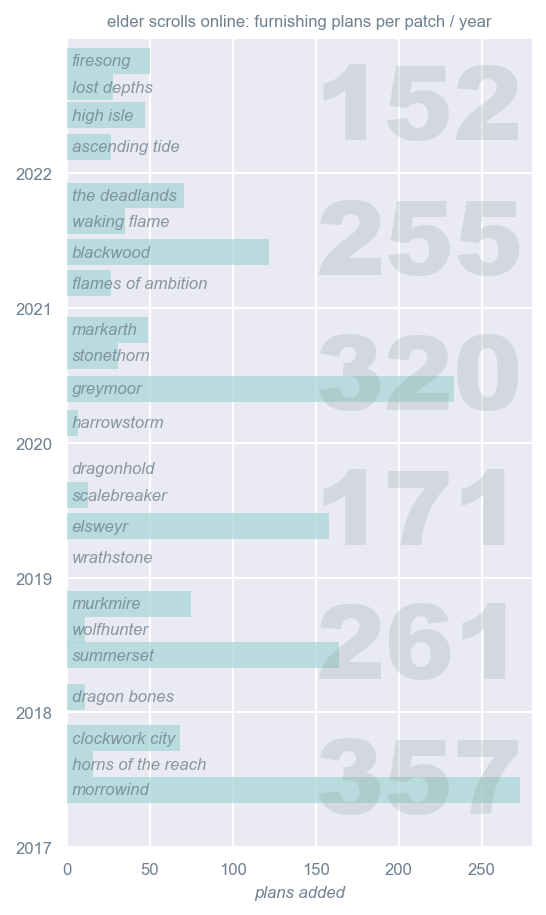

In [48]:
plt.style.use("seaborn")

# create a horizontal bar chart of the number of plans released per patch
x = patches["Release"]
y = patches["Plans"]

fig, ax = plt.subplots(figsize=(4, 7))

ax.set_title("elder scrolls online: furnishing plans per patch / year", **titlefnt)
ax.barh(x, y, height=70, color="#a9d6d6", align="center", alpha=0.75)

ax.set_xlim(0, 280)
ax.set_ylim(xl2019, xr2022)
ax.set_xlabel("plans added", c="slategray", style="italic", size=8)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # xtick label format
ax.tick_params(labelsize=8, labelcolor="slategrey", size=0)

for patch, release in zip(patches["Patch"], patches["Release"]):
    ax.text(y=release, x=3, s=patch.lower(), **bar_text2)

year_sums = patches.groupby(patches["Release"].dt.year)["Plans"].sum()

for year in list(year_sums.index):
    ax.text(
        y=datetime(year, 6, 15, 0, 0, 0),
        x=275,
        s=str(int(year_sums[year])),
        **bar_text3,
    )

fig.savefig("images/ESOPlanMats_year.png", bbox_inches="tight")

### Elder Scrolls Online: Furnishing Plans Added Per Patch *(horizontal bar chart)*

Each horizontal bar shows the number of plans added by the patch, with the years shown on the y-axis and the yearly totals listed on the far right.

As mentioned above, the total number of plans added per year has been significantly lower in 2022 than past years. The only comparable year's total is 2019 (Wrathstone, Elsweyr, Scalebreaker, Dragonhold), which was notably a year with severe enough performance issues that a planned event urging players to simply complete group dungeon content had to be cancelled last second and replaced with a repeat of an event from only a couple of months earlier. The priority of performance improvements over new content can be seen in the total lack of new furnishing plans in the Q4 Dragonhold patch.

The total number of plans added per individual patch could be expected to increase any price changes, but would need to be interpreted alongside the types of plans added by each update.

###### Find material sums per furnishing category

In [49]:
# group by category and find the sum of each, & swap rows/columns
cat_sum = plans.groupby(["Category"]).sum(numeric_only=True)
cat_sum = cat_sum.transpose()

# remove mat sum column
cat_sum = cat_sum.drop("Mat Sum")

# get unique category names and sort alphabetically
categories = pd.unique(plans["Category"])
categories.sort()

# fix order of mats to match other dataframes
cat_sum = cat_sum.reindex(list(mat_names.values()))

cat_sum.head(3)

Category,Conservatory,Courtyard,Dining,Gallery,Hearth,Library,Lighting,Miscellaneous,Parlor,Services,Structures,Suite,Undercroft,Workshop
Regulus,55.0,334.0,649.0,198.0,1744.0,356.0,2143.0,9.0,539.0,58.0,639.0,1096.0,522.0,711.0
Bast,0.0,127.0,321.0,62.0,220.0,116.0,83.0,52.0,2012.0,0.0,267.0,940.0,70.0,232.0
Wood,91.0,476.0,2214.0,221.0,1358.0,1265.0,499.0,10.0,684.0,28.0,710.0,2255.0,249.0,465.0


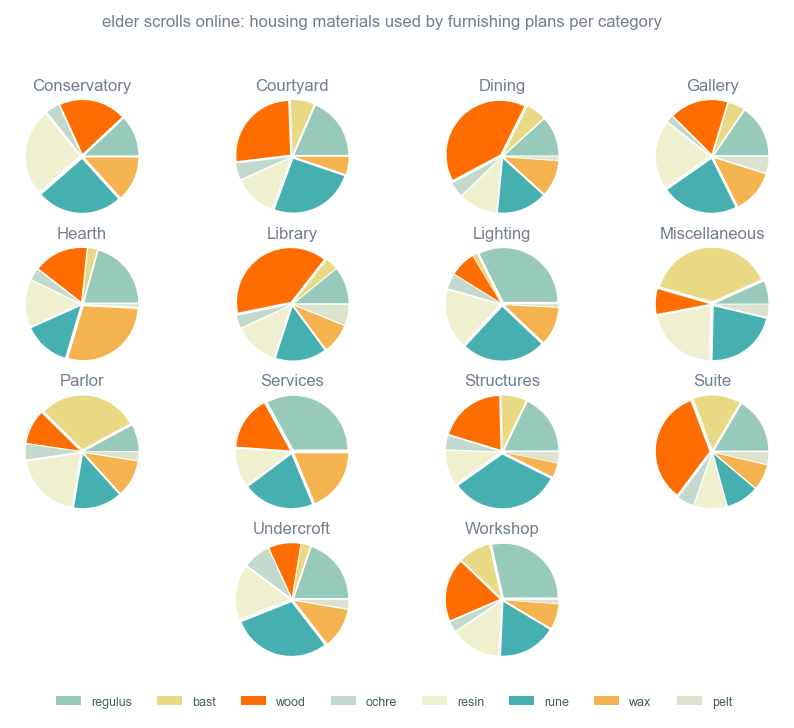

In [50]:
fig, axs = plt.subplots(4, 4, dpi=150, figsize=(8, 5), facecolor="w")
plt.subplots_adjust(hspace=0.1, wspace=-0.3)
fig.suptitle(
    "elder scrolls online: housing materials used by furnishing plans per category",
    **titlefnt,
)

# create list for chart explode
expl = [explode] * len(colors.keys())

# make a pie chart for each category's materials
for cat, ax in zip(categories, axs.ravel()):
    cat_sum[cat].plot.pie(
        ax=ax,
        labels=list(cat_sum.index),
        explode=expl,
        colors=[colors[key] for key in labels],
        **pie,
    )
    ax.set_title(label=cat, y=0.9, **titlefnt)
    ax.set_ylabel("")

# add legend to bottom center
plt.figlegend(labels=labels, bbox_to_anchor=(0.51, 0.04), **legend)

# get position of center pie charts in last row
second = axs[3][1].get_position()
third = axs[3][2].get_position()

# move last row of plots to the center
axs[3][0].set_position(second)
axs[3][1].set_position(third)

# remove empty plots
fig.delaxes(axs[3][2])
fig.delaxes(axs[3][3])

fig.savefig("images/ESOPlanMats_cat.png", bbox_inches="tight")

### Elder Scrolls Online: Housing Materials Used By Furnishing Plans Per Category *(pie charts)*

Each pie chart shows the ratio of materials used by all plans, sorted only by furnishing category. Library, dining, and suite furnishings clearly use disproportionate amounts of heartwood; structure and undercroft furnishings use disproportionate amounts of mundane runes. Although the exact furnishings used would be expected to vary dramatically based on player intent and the items available at the time, the larger number of categories with heavy use of heartwood and the fact that nearly all furnishings used for custom buildings are listed as structures (which relies heavily on mundane runes) could explain why those materials show the most extreme price increases over the years. Despite being (presumably) less used than structures and typical furnishings (beds, tables, shelves, etc), the hearth category's high usage of decorative wax is likely enough to explain the similar price increases for that material.

![](https://raw.githubusercontent.com/racheldelong/ESO-Crafting-Material-Prices/main/images/CKy_prices2.png)

Since the Firesong DLC recently added the ability to export lists of furnishings used in any player's home, I plan to add lists of furnishings from a random sample of builds to see how many items are typically used from each category and combine with the material usage and category data.